In [1]:
!which python

/home/paperspace/anaconda3/envs/fastai/bin/python


In [2]:
import enum
import math
import pdb
import platform
import time

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook

from ssdmultibox.criterion import SSDLoss
from ssdmultibox.datasets import PascalDataset, TrainPascalFlatDataset, device
from ssdmultibox.models import SSDModel
from ssdmultibox import utils
from ssdmultibox.plotting import *

import matplotlib.pyplot as plt
plt.ion()

In [3]:
device

device(type='cuda', index=0)

In [4]:
losses = {'total':[], 'loc':[], 'conf':[]}

In [5]:
model = SSDModel().to(device)

In [6]:
!ls model_checkpoints/

model-2018-12-11T09:46:00.cpkt	model-2018-12-12T09:42:45.cpkt
model-2018-12-11T09:48:13.cpkt


In [7]:
model.load_state_dict(torch.load('model_checkpoints/model-2018-12-11T09:48:13.cpkt'))

In [41]:
LR = 1e-3
SSD_LOSS_ALPHA = .2

criterion = SSDLoss(alpha=SSD_LOSS_ALPHA)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
current_time = time.time()

In [42]:
train_dataset = TrainPascalFlatDataset()

len(train_dataset)

2501

In [43]:
NUM_WORKERS = utils.get_cpu_count()
BATCH = 16
SHUFFLE = True
    
dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUM_WORKERS)

vars(dataloader)

{'dataset': <ssdmultibox.datasets.TrainPascalFlatDataset at 0x7f44830382e8>,
 'batch_size': 16,
 'num_workers': 8,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7f448029e0b8>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f448029e320>,
 '_DataLoader__initialized': True}

In [44]:
EPOCHS = 1

for epoch in range(EPOCHS):
    scheduler.step()
    steps = math.ceil(len(train_dataset) / BATCH)
    for step in tqdm_notebook(range(steps)):
        image_ids, ims, gt_bbs, gt_cats = next(iter(dataloader))

        # put data on device
        ims, gt_bbs, gt_cats = PascalDataset.to_device(ims, gt_bbs, gt_cats)

        # zero out gradients
        optimizer.zero_grad()

        # forward pass
        preds = model(ims)
        loss, loc_loss, conf_loss = criterion(preds, (gt_bbs, gt_cats))

        # backward pass
        loss.backward()
        optimizer.step()

        # stats
        if step % 5 == 0:
            print('epoch: {} step: {} loss: {:.4f} time: {:.4f}'.format(
                epoch, step, loss.item(), time.time() - current_time))
            current_time = time.time()
            losses['total'].append(loss.item())
            losses['loc'].append(loc_loss.item())
            losses['conf'].append(conf_loss.item())

pos_loss: 283.9777 neg_hard_mining_loss: 11.5012
n: 84.0 bbs_loss: 886.5895 cats_loss: 295.4789
epoch: 0 step: 0 loss: 14.0722 time: 22.1919
pos_loss: 342.6922 neg_hard_mining_loss: 17.4169
n: 119.0 bbs_loss: 1597.4879 cats_loss: 360.1092
pos_loss: 533.2086 neg_hard_mining_loss: 33.6561
n: 158.0 bbs_loss: 1989.8311 cats_loss: 566.8647
pos_loss: 327.9855 neg_hard_mining_loss: 10.2058
n: 95.0 bbs_loss: 1103.3314 cats_loss: 338.1914
pos_loss: 318.0870 neg_hard_mining_loss: 15.9218
n: 87.0 bbs_loss: 1279.2865 cats_loss: 334.0089
pos_loss: 389.1136 neg_hard_mining_loss: 37.8563
n: 135.0 bbs_loss: 1576.9379 cats_loss: 426.9698
epoch: 0 step: 5 loss: 14.8438 time: 9.4604
pos_loss: 302.1234 neg_hard_mining_loss: 27.2272
n: 93.0 bbs_loss: 1036.5950 cats_loss: 329.3506
pos_loss: 516.8127 neg_hard_mining_loss: 37.8027
n: 160.0 bbs_loss: 1574.4111 cats_loss: 554.6155
pos_loss: 546.4633 neg_hard_mining_loss: 34.1725
n: 170.0 bbs_loss: 1939.6581 cats_loss: 580.6359
pos_loss: 452.5401 neg_hard_mining

pos_loss: 316.7460 neg_hard_mining_loss: 6.2433
n: 103.0 bbs_loss: 1230.6844 cats_loss: 322.9893
pos_loss: 373.0719 neg_hard_mining_loss: 2.9390
n: 103.0 bbs_loss: 1559.1250 cats_loss: 376.0109
pos_loss: 442.1183 neg_hard_mining_loss: 12.0919
n: 118.0 bbs_loss: 1447.4471 cats_loss: 454.2102
pos_loss: 321.9973 neg_hard_mining_loss: 5.9924
n: 93.0 bbs_loss: 1095.1755 cats_loss: 327.9897
epoch: 0 step: 80 loss: 15.3029 time: 9.2913
pos_loss: 294.4936 neg_hard_mining_loss: 10.3640
n: 138.0 bbs_loss: 1717.2557 cats_loss: 304.8576
pos_loss: 422.5937 neg_hard_mining_loss: 3.2683
n: 118.0 bbs_loss: 1317.9945 cats_loss: 425.8620
pos_loss: 358.4099 neg_hard_mining_loss: 14.2480
n: 121.0 bbs_loss: 1651.8041 cats_loss: 372.6579
pos_loss: 485.6992 neg_hard_mining_loss: 7.0666
n: 136.0 bbs_loss: 1746.8070 cats_loss: 492.7659
pos_loss: 505.6354 neg_hard_mining_loss: 7.2966
n: 137.0 bbs_loss: 1745.7767 cats_loss: 512.9319
epoch: 0 step: 85 loss: 16.4869 time: 9.5507
pos_loss: 268.2416 neg_hard_mining_

pos_loss: 446.8881 neg_hard_mining_loss: 4.8453
n: 145.0 bbs_loss: 1885.0179 cats_loss: 451.7334
epoch: 0 step: 155 loss: 16.1155 time: 9.6994
pos_loss: 351.9104 neg_hard_mining_loss: 1.8412
n: 106.0 bbs_loss: 1489.9274 cats_loss: 353.7516



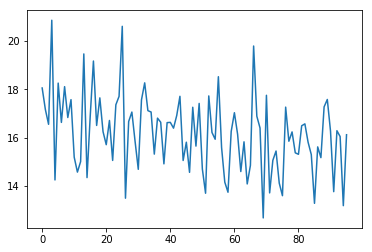

In [45]:
plt.plot(losses['total'])

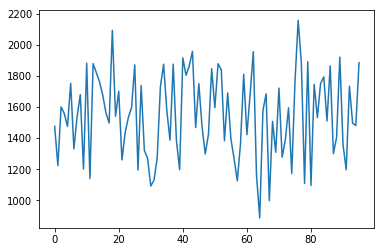

In [46]:
plt.plot(losses['loc'])

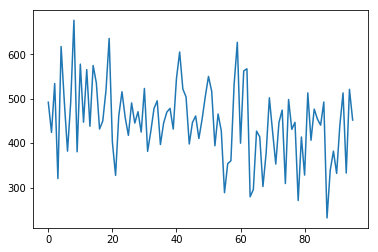

In [47]:
plt.plot(losses['conf'])

In [48]:
utils.save_model(model)

model saved at: model_checkpoints/model-2018-12-12T10:23:41.cpkt


In [49]:
bbs_preds, cats_preds = preds

## plotting

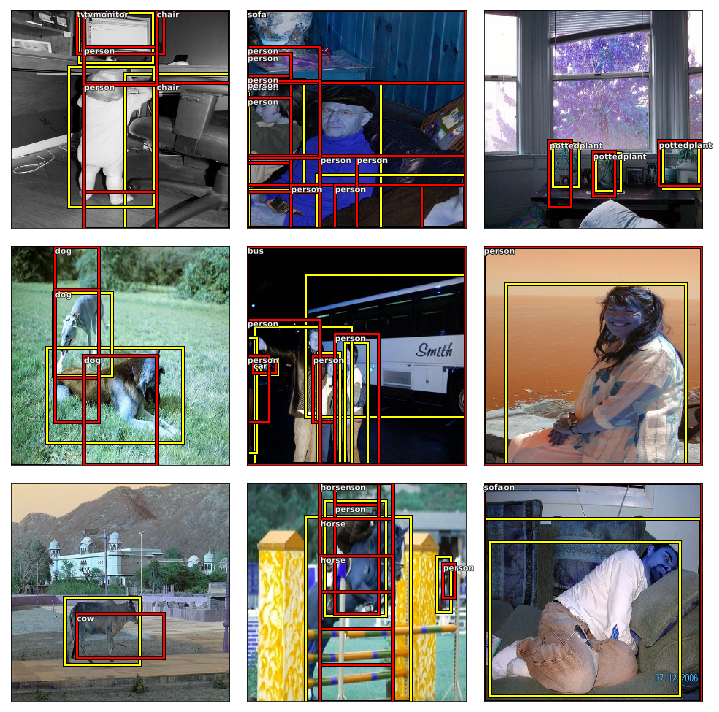

In [50]:
dataset = train_dataset

plot_multiple(plot_anchor_bbs, plots=(3,3), dataset=dataset, image_ids=image_ids, gt_cats=gt_cats)

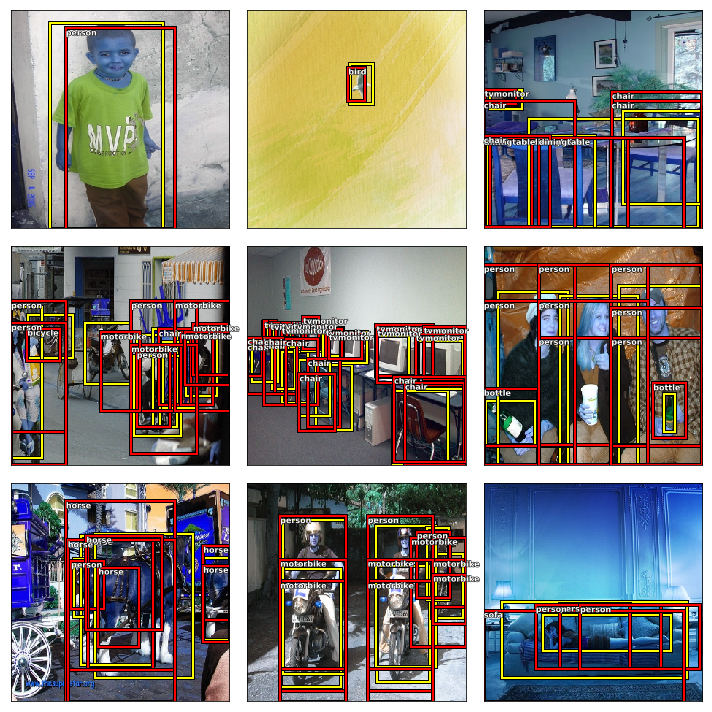

In [19]:
plot_multiple(plot_preds, plots=(3,3), dataset=dataset, image_ids=image_ids, gt_cats=gt_cats, bbs_preds=bbs_preds)

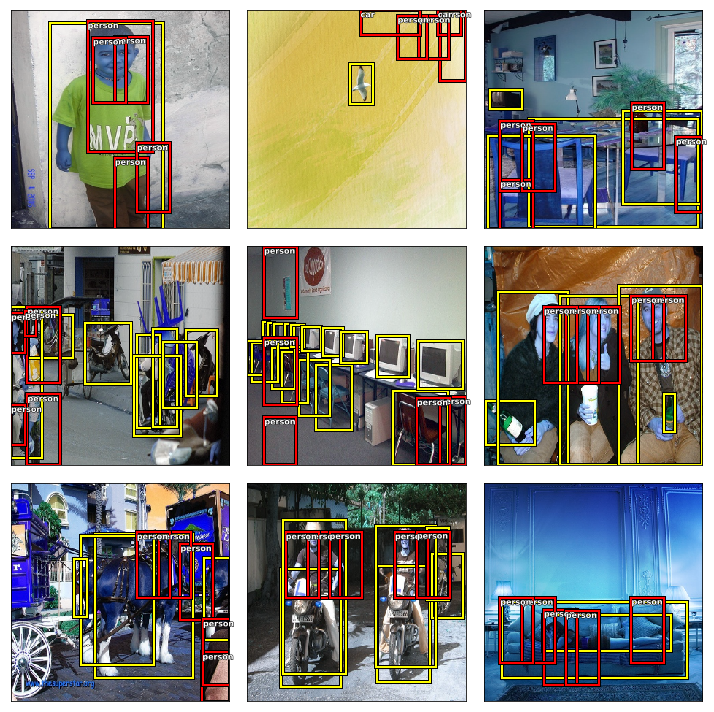

In [20]:
plot_multiple(plot_nms_preds, plots=(3,3), dataset=dataset, image_ids=image_ids, preds=preds)

In [21]:
debug_batch = 4

class DebugDataset(TrainPascalFlatDataset):
    def __len__(self):
        return debug_batch

debug_dataset = DebugDataset()

In [22]:
debug_dataloader = DataLoader(train_dataset, batch_size=debug_batch, shuffle=False, num_workers=NUM_WORKERS)

vars(debug_dataloader)

{'dataset': <ssdmultibox.datasets.TrainPascalFlatDataset at 0x7f4484b48080>,
 'batch_size': 4,
 'num_workers': 8,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.SequentialSampler at 0x7f4482401710>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f4482401e10>,
 '_DataLoader__initialized': True}

In [23]:
image_ids, ims, gt_bbs, gt_cats = next(iter(debug_dataloader))

# put data on device
ims, gt_bbs, gt_cats = PascalDataset.to_device(ims, gt_bbs, gt_cats)
preds = model(ims)

In [24]:
bbs_preds, cats_preds = preds

bbs_preds.shape, cats_preds.shape

(torch.Size([4, 11640, 4]), torch.Size([4, 11640, 21]))

In [25]:
image_ids

tensor([12, 17, 23, 26])

In [26]:
mask = gt_cats != 20
gt_cats[mask]

tensor([ 6,  6,  6,  6, 14, 14, 12,  1,  1,  1, 14, 14, 14, 14,  1,  1, 14, 14,
        14, 14,  1,  1,  1,  1, 14, 14, 14, 14, 14, 14,  6,  6,  6,  6,  6,  6,
         6], device='cuda:0')

In [27]:
dataset = debug_dataset
# plot_multiple(plot_nms_preds, dataset=dataset, image_ids=image_ids, preds=preds)

In [28]:
idx = 0
cls_id = 6
item_bbs = bbs_preds[idx]
item_cats = cats_preds[idx]

Predict.single_nms(cls_id, item_bbs, item_cats)

(tensor([[155.2303,  88.0506, 176.2905, 118.2781],
         [110.8517, 142.6015, 128.3377, 157.4324],
         [155.6584,  72.3884, 176.1472, 102.5897],
         [139.9590,  72.2109, 160.3710, 102.6957],
         [  0.0000, 125.3529,  34.3735, 206.5635],
         [110.6816, 126.8743, 128.0327, 141.7810],
         [170.8790,  88.1414, 192.1246, 118.3184],
         [111.0325, 158.3011, 128.3809, 172.8921],
         [  0.0000, 260.7160,  34.1272, 293.6039],
         [  0.0000,  95.4385,  34.0317, 176.9118],
         [141.9483,  78.7602, 159.2287,  94.9811],
         [  0.0000, 155.0793,  34.3281, 236.3182],
         [126.5914, 142.5592, 144.0733, 157.2369],
         [126.5060,  78.9606, 143.3352,  94.9371],
         [126.4547, 158.2469, 144.1808, 172.7239],
         [139.7354,  87.8895, 160.3089, 118.5087],
         [157.4830,  78.7004, 174.9583,  95.0486],
         [  0.0000, 184.7220,  33.9511, 266.6671],
         [282.0938,   7.9734, 300.0000,  39.0274],
         [264.3228,   5.7612, 3

In [29]:
item_cats[mask[0]], item_cats[mask[0]].shape

(tensor([[-3.3954, -3.8684, -2.9991, -3.8224, -4.2716, -3.7374, -2.4276, -3.5843,
          -2.8645, -4.1546, -3.1889, -3.0503, -3.1169, -2.9541, -0.9620, -3.4995,
          -4.2094, -3.0048, -3.1746, -3.0949, -0.0128],
         [-4.8320, -4.3453, -3.1389, -3.9983, -3.9951, -4.7344, -3.5122, -3.6482,
          -3.8631, -4.2637, -4.5369, -2.1456, -2.4304, -4.0743, -0.4753, -3.7635,
          -4.5589, -3.4626, -3.6194, -3.5925,  0.0977],
         [-4.5433, -3.5109, -2.6823, -4.1917, -3.3642, -4.1090, -2.7827, -2.5902,
          -2.6947, -3.4517, -4.0738, -1.8973, -1.7550, -2.7097, -0.5027, -3.5335,
          -3.6483, -2.4958, -3.6225, -3.6270, -0.2545],
         [-3.7860, -3.4613, -2.9391, -3.8330, -4.3594, -3.6677, -2.3389, -3.7590,
          -2.8935, -4.0319, -3.3788, -2.7646, -2.9231, -3.0432, -1.0010, -3.5203,
          -4.0454, -2.9558, -2.9651, -3.2460, -0.2044]],
        device='cuda:0', grad_fn=<TakeBackward>), torch.Size([4, 21]))

In [30]:
item_cats[mask[0]][:,:-1].max(1)

(tensor([-0.9620, -0.4753, -0.5027, -1.0010], device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([14, 14, 14, 14], device='cuda:0'))

In [31]:
item_cats[mask[0]].min(1)

(tensor([-4.2716, -4.8320, -4.5433, -4.3594], device='cuda:0', grad_fn=<MinBackward0>),
 tensor([4, 0, 0, 4], device='cuda:0'))

In [32]:
# look at trainable model layers

In [33]:
for i, layer in enumerate(model.parameters()):
    print(i, layer.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 True
59 True
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 True
69 True
70 True
71 True
72 True
73 True
74 True
75 True
76 True
77 True
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 True
105 True
106 True
107 True
108 True
109 True
110 True
111 True
112 True
113 True
114 True
115 True
116 True

In [39]:
for i, layer in enumerate(model.parameters()):
    layer.requires_grad = True

In [40]:
for i, layer in enumerate(model.parameters()):
    print(i, layer.requires_grad)

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True
34 True
35 True
36 True
37 True
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 True
50 True
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 True
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 True
69 True
70 True
71 True
72 True
73 True
74 True
75 True
76 True
77 True
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 True
105 True
106 True
107 True
108 True
109 True
110 True
111 True
112 True
113 True
114 True
115 True
116 True
117 True
118 True
119 True
120 True
121 True
122 True
123